# Imports

In [4]:
!python3 -m pip install scikit-learn==0.24.2

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 22.2 MB 7.3 MB/s            
     |████████████████████████████████| 309 kB 8.5 MB/s            


In [5]:
!python3 -m pip install pandas==1.1.5

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 9.5 MB 1.5 MB/s            


In [6]:
%load_ext autoreload
%autoreload 2

import json
import os
from pathlib import Path
from PIL import Image


from imgaug.augmentables.kps import KeypointsOnImage
from imgaug.augmentables.kps import Keypoint
import imgaug.augmenters as iaa
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from pitch_geo.data import KeyPointsDataset
import vis_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read the data frame

In [7]:
df = pd.read_csv('recruitment_task_pitch_geom/df_keypoints.csv')

I think that there is one row which is mislabeled. There shouldbe 39 instead of 38.

In [8]:
df = df[df['dataset'] == 'train']

In [9]:
key = df.query('kid == 38 and vis != 0')['image_path'].item()
idx1 = df.query(f'kid == 39 and image_path == "{key}"').index
idx2 = df.query(f'kid == 38 and image_path == "{key}"').index
df.loc[idx1, 'x'] = df.loc[idx2, 'x'].item()
df.loc[idx1, 'y'] = df.loc[idx2, 'y'].item()
df.loc[idx1, 'vis'] = df.loc[idx2, 'vis'].item()

Now when 'kid' is 38 the keypoint is always marked as invisible. Drop all the rows with 'kid' == 38 as they don't contain any information.

In [10]:
df = df[df['kid'] != 38]
df['kid'].nunique()

38

# Define hyperparameters

In [11]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 1
NUM_KEYPOINTS = 38 * 2  # 38 pairs each having x and y coordinates
DATA_FOLDER = Path('recruitment_task_pitch_geom')

In [12]:
df

,x,y,vis,kid,dataset,image_path
0,532,158,2,1,train,images/train/c814ce8e31e077df861c2848fe14fb.jpg
1,1732,227,2,2,train,images/train/c814ce8e31e077df861c2848fe14fb.jpg
2,0,0,0,3,train,images/train/c814ce8e31e077df861c2848fe14fb.jpg
3,0,0,0,4,train,images/train/c814ce8e31e077df861c2848fe14fb.jpg
4,359,203,2,5,train,images/train/c814ce8e31e077df861c2848fe14fb.jpg
...,...,...,...,...,...,...
149052,0,0,0,34,train,images/train/bb5cbf42a7c0f05a6ef82530351309.jpg
149053,0,0,0,35,train,images/train/bb5cbf42a7c0f05a6ef82530351309.jpg
149054,0,0,0,36,train,images/train/bb5cbf42a7c0f05a6ef82530351309.jpg
149055,0,0,0,37,train,images/train/bb5cbf42a7c0f05a6ef82530351309.jpg


In [13]:
from pitch_geo.data import read_image_and_keypoints

In [14]:
img, kps = read_image_and_keypoints(
    img_path='images/train/c814ce8e31e077df861c2848fe14fb.jpg',
    df=df,
    root_data_path=DATA_FOLDER
)

# Degine augmentation

In [15]:
train_aug = iaa.Sequential(
    [
        iaa.Resize(IMG_SIZE, interpolation="linear"),
        iaa.Fliplr(0.3),
        # `Sometimes()` applies a function randomly to the inputs with
        # a given probability (0.3, in this case).
        iaa.Sometimes(0.3, iaa.Affine(rotate=10, scale=(0.5, 0.7))),
    ]
)

test_aug = iaa.Sequential([iaa.Resize(IMG_SIZE, interpolation="linear")])

In [16]:
train_dataset = KeyPointsDataset(df=df, aug=train_aug, batch_size=32, train=True)

In [17]:
df['image_path'].nunique() / 32

119.4375

In [18]:
print(f"Total batches in training set: {len(train_dataset)}")

Total batches in training set: 119


In [19]:
sample_images, sample_keypoints = next(iter(train_dataset))
assert sample_keypoints.max() == 1.0
assert sample_keypoints.min() == 0.0

In [20]:
sample_keypoints.shape

(32, 1, 1, 76)

In [21]:
sample_keypoints = sample_keypoints[:4].reshape(-1, 38, 2) * IMG_SIZE

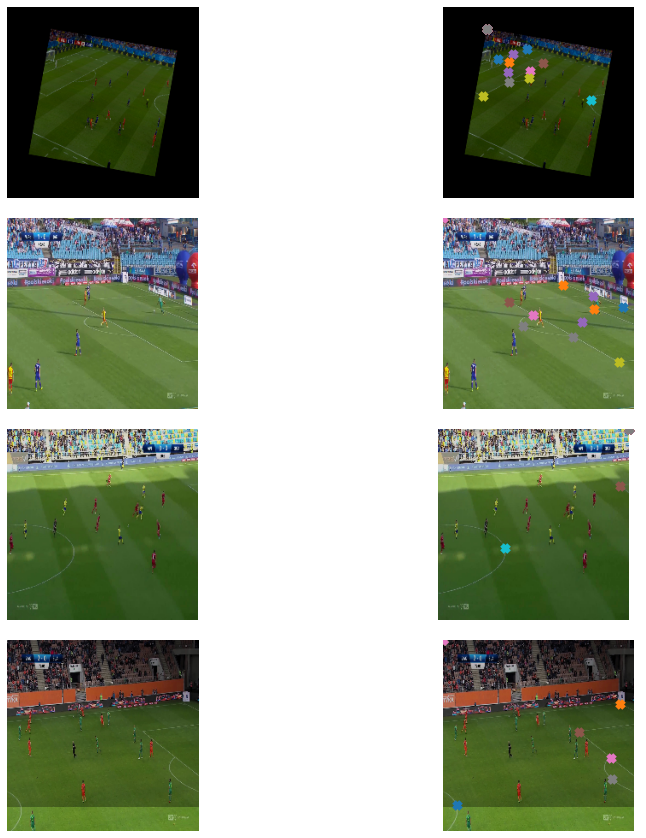

In [22]:
vis_utils.visualize_keypoints(sample_images[:4], sample_keypoints)

# Prepare the data loaders

In [23]:
from sklearn.model_selection import train_test_split

images_paths = df['image_path'].unique()

train_paths, test_paths = train_test_split(images_paths, test_size=0.15, random_state=42, shuffle=True)

In [24]:
train_df = df[df['image_path'].isin(train_paths)]
val_df = df[~df['image_path'].isin(train_paths)]

In [25]:
train_dataset = KeyPointsDataset(df=train_df, aug=train_aug, batch_size=BATCH_SIZE, train=True)
val_dataset = KeyPointsDataset(df=val_df, aug=test_aug, batch_size=BATCH_SIZE, train=False)

print(f"Total batches in training set: {len(train_dataset)}")
print(f"Total batches in validation set: {len(val_dataset)}")

Total batches in training set: 50
Total batches in validation set: 8


# The model

## Model building

In [26]:
def get_model():
    # Load the pre-trained weights of MobileNetV2 and freeze the weights
    backbone = keras.applications.MobileNetV2(
        weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    backbone.trainable = False

    inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
    x = keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = backbone(x)
    x = layers.Dropout(0.3)(x)
    x = layers.SeparableConv2D(
        NUM_KEYPOINTS, kernel_size=5, strides=1, activation="relu"
    )(x)
    outputs = layers.SeparableConv2D(
        NUM_KEYPOINTS, kernel_size=3, strides=1, activation="sigmoid"
    )(x)

    return keras.Model(inputs, outputs, name="keypoint_detector")

## Compile the model

In [27]:
model = get_model()
model.compile(loss="mse", optimizer=keras.optimizers.Adam(1e-4))

9412608/9406464 [==============================] - 1s 0us/step


## Train the model

In [28]:
# for i, batch in enumerate(train_dataset):
#     print(f'{i + 1}/{len(train_dataset)}', end='\r')
#     continue

In [29]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS)

50/50 [==============================] - 148s 3s/step - loss: 0.1661 - val_loss: 0.1931


In [30]:
history.history['val_loss']

[0.19307240843772888]

In [31]:
sample_val_images, sample_val_keypoints = next(iter(val_dataset))
sample_val_images = sample_val_images[:4]
sample_val_keypoints = sample_val_keypoints[:4].reshape(-1, 38, 2) * IMG_SIZE

In [32]:
predictions = model.predict(sample_val_images).reshape(-1, 38, 2) * IMG_SIZE

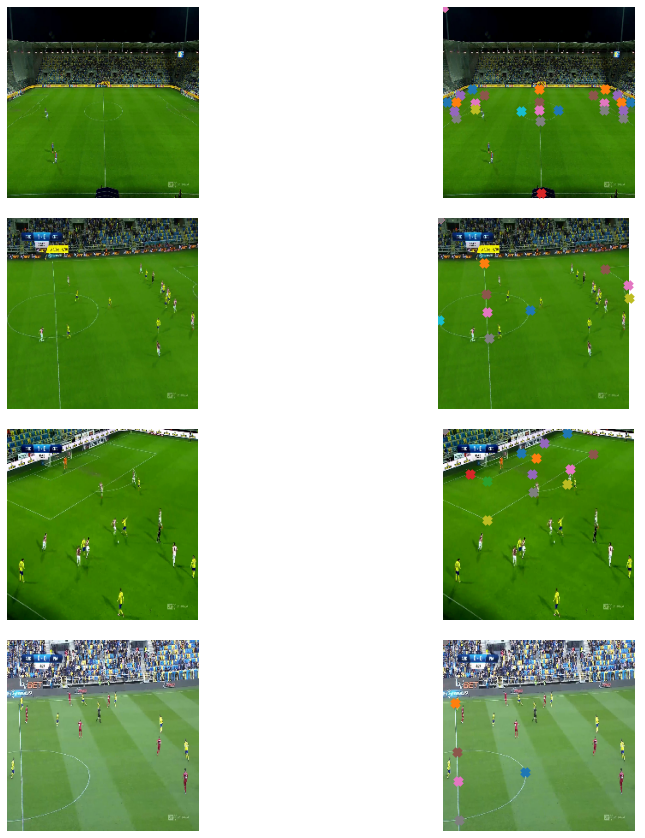

In [33]:
# Ground-truth
vis_utils.visualize_keypoints(sample_val_images, sample_val_keypoints)

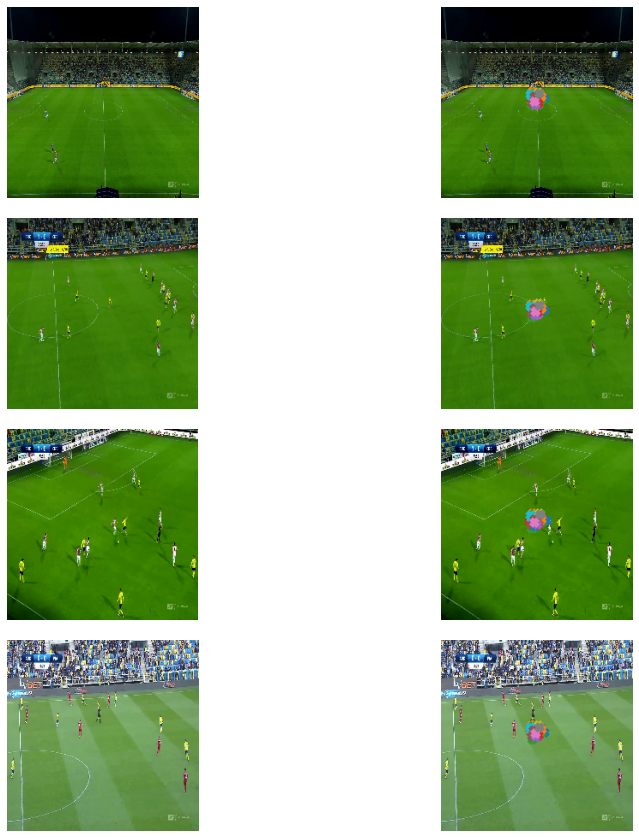

In [34]:
# Predictions
vis_utils.visualize_keypoints(sample_val_images, predictions)

# Test the model

In [35]:
batch = next(iter(val_dataset))

In [39]:
batch[0].shape

(64, 224, 224, 3)

In [40]:
batch[1].shape

(64, 1, 1, 76)

In [42]:
y = model.predict(batch[0])

In [66]:
x = np.zeros_like(y)

In [63]:
x.reshape((*x.shape[:-1], 2))

ValueError: cannot reshape array of size 4864 into shape (64,1,1,2)

In [73]:
x

array([[[ 532,  158, 1732,  227,    0,    0,    0,    0,  359,  203,
          723,  234,  564,  300,  290,  410,    0,    0,    0,    0,
          174,  250,  300,  264,    0,    0,    0,    0,  276,  336,
         1718,  383, 1712,  474, 1702,  596,  561,  358, 1332,  443,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0]]])

In [75]:
x.reshape(1, 38, 2)[0,0,:]

array([532, 158])

In [74]:
df[df['image_path'] == 'images/train/c814ce8e31e077df861c2848fe14fb.jpg'][['x', 'y']]

,x,y
0,532,158
1,1732,227
2,0,0
3,0,0
4,359,203
5,723,234
6,564,300
7,290,410
8,0,0
9,0,0


In [50]:
np.linalg.norm(y - x)

33.89141

In [68]:
x = df[df['image_path'] == 'images/train/c814ce8e31e077df861c2848fe14fb.jpg'][['x', 'y']].values.reshape(1, 1, 38 * 2)

In [76]:
(df[df['image_path'] == 'images/train/c814ce8e31e077df861c2848fe14fb.jpg']['vis'] == 0).values

array([False, False,  True,  True, False, False, False, False,  True,
        True, False, False,  True,  True, False, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])